In [9]:
###A Modern Geospatial Workflow in Python###

# What kind of python libraries make up a modern geospatial workflow? This is just a sample of what
# we consider to be the basic building blocks and what will be covered here:

#     shapely for geometric analysis
#     fiona for reading in vector formats
#     rasterio for reading in and working with raster formats
#     GeoPandas to extend pandas to work with geo formats
#     numpy and the python scientific computing stack for efficient computation
#     matplotlib for general plotting and visualization
#     folium for advanced and interactive plotting
#     scikit-learn for machine learning based data exploration, classification, and regression

import rasterio as rio
from rasterio.plot import show
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import folium
import os
import fnmatch
from TOA_Reflectance_Stacker import histogram_stretch
from tqdm import tqdm
import earthpy.plot as ep
import shapely

In [ ]:
### SENTINEL 2 DATA ###
# Tutorial for navigating Copernicus Open Access Hub
# https://www.youtube.com/watch?v=l5ZIKZi5Qbw

# Different sentinel 2 product types
# https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-2-msi/product-types

# Looks like most sentinel 2 products are already TOA corrected

In [2]:
### nagasaki_toa.tif created using TOA reflectance stacker code + crop to study area
# gdalwarp -t_srs EPSG:3098 -te 547579 3600677 631939 3667730
# "C:\..\LC08_L1TP_113037_20230502_20230509_02_T1_TOA_STACKED.tif" nagasaki_toa.tif

# Plot a stretched TCC and FCC image
src = rio.open("nagasaki_toa.tif")
src.meta

nir = src.read(5)
red = src.read(4)
green = src.read(3)
blue = src.read(2)

src.close()

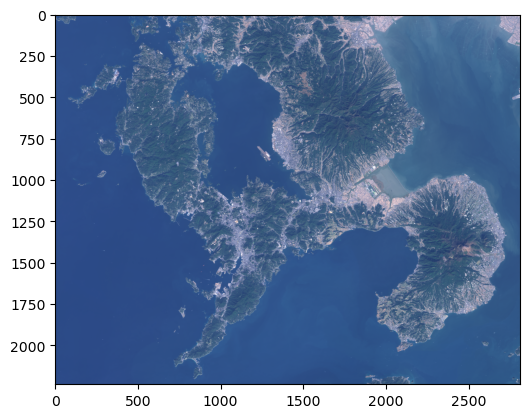

<Axes: >

In [16]:
import rasterio as rio
from rasterio.plot import show

src = rio.open("LC08_L1TP_113037_20211120_20211130_02_T1_TOA_STACKED_CROPPED.tif")

# test = src.read()

# test.shape

show(src.read([4,3,2]))

In [15]:
polygon = shapely.geometry.box(*src.bounds)

df = gpd.GeoSeries([polygon], crs = "EPSG:3098")

df.to_file("study_area.geojson", driver = "GeoJSON")

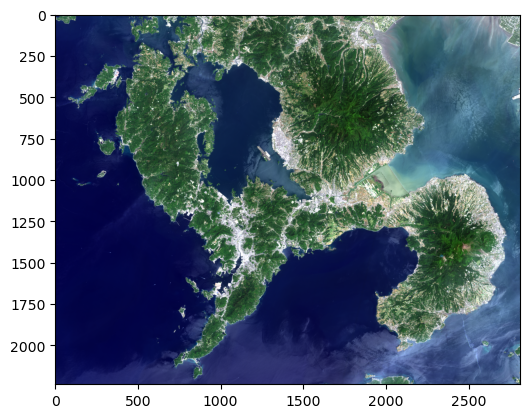

<Axes: >

In [3]:
tcc = np.stack([red, green, blue], axis = 0)
tcc_stretch = histogram_stretch(tcc, min_vals = 0)
show(tcc_stretch)

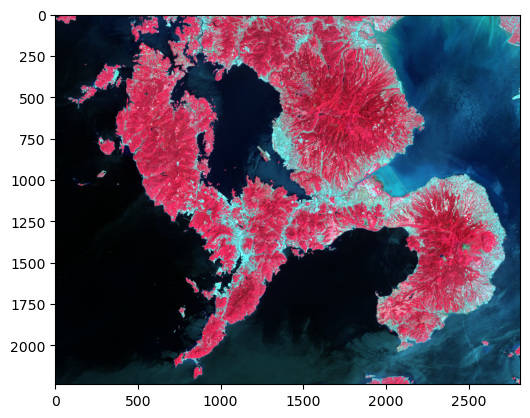

<Axes: >

In [10]:
fcc = np.stack([nir, red, green], axis = 0)
fcc_stretch = histogram_stretch(fcc, min_vals = 0)
show(fcc_stretch)

<Axes: >

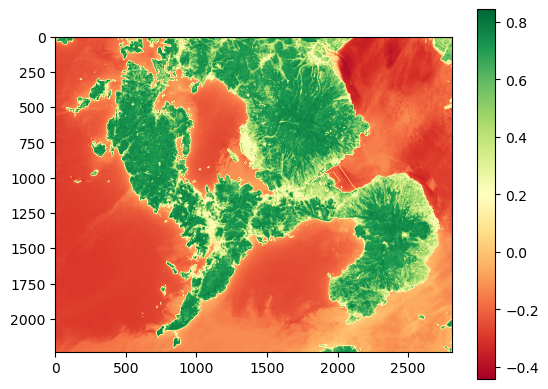

In [14]:
ndvi = (nir - red) / (nir + red)

fig, ax = plt.subplots()

# workaround to get colobar with rio.plot.show
image_hidden = ax.imshow(ndvi, cmap = "RdYlGn")
fig.colorbar(image_hidden, ax=ax)
show(ndvi, cmap = "RdYlGn", ax = ax)

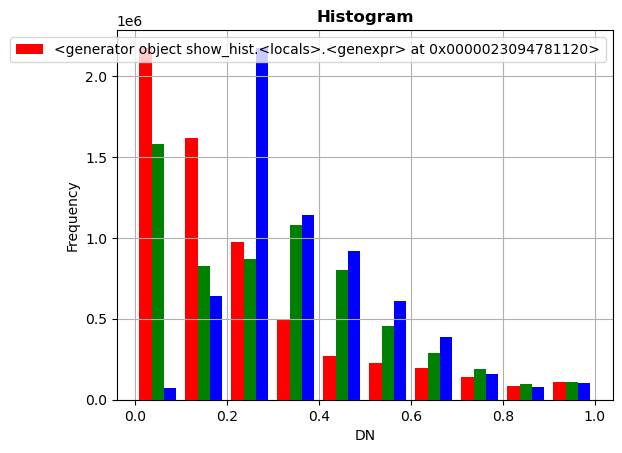

In [11]:
rio.plot.show_hist(tcc_stretch)

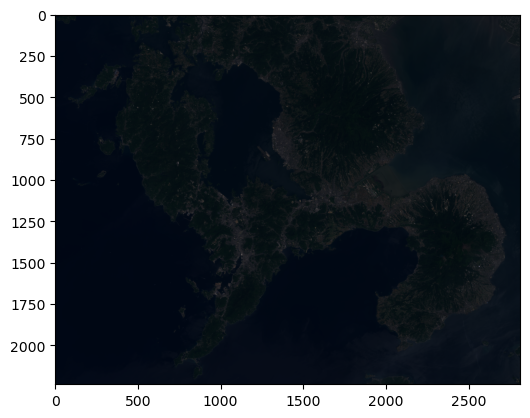

In [16]:
### RIO has its own normalization but its not as good as mine ;) ###
# rgb_norm = rio.plot.adjust_band(tcc)
# rgb_reshaped = rio.plot.reshape_as_image(rgb_norm) # reshape to [rows, cols, bands]

# fig, ax = plt.subplots()
# ax.imshow(rgb_reshaped)

In [4]:
# Let's try some super basic kmeans 
from sklearn import cluster

src = rio.open("nagasaki_toa.tif")

dataset = src.read()

dataset.shape

(7, 2235, 2812)

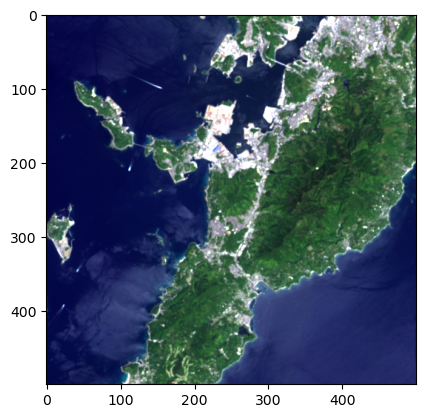

<Axes: >

In [5]:
# Study area
show(tcc_stretch[:, 1500:2000, 750:1250])

In [5]:
training = dataset[:, 1500:2000, 750:1250]

new_shape = (training.shape[1] * training.shape[2], training.shape[0])

# Note that we need to reshape the training data so that each element contains the values of the 
# landsat bands in order

# This helped me a lot:
# https://stackoverflow.com/questions/35226115/numpy-reshaping-multdimensional-array-through-arbitrary-axis

# EXAMPLE: 
# This is a 3 band 2x4 image
# test = np.arange(24).reshape(3,2,4)

# print(test)
# [[[ 0  1  2  3]
#   [ 4  5  6  7]]

#  [[ 8  9 10 11]
#   [12 13 14 15]]

#  [[16 17 18 19]
#   [20 21 22 23]]]

# For pixel 1, the values are 0, 8, 16
# We have to make sure that 0,8,16 are close together so that they can be reshaped properly

# We can use swapaxes to swap the bands and the columns - flatten will then give us the desired result
# test.swapaxes(0, 2)
#       [[[ 0,  8, 16],
#         [ 4, 12, 20]],

#        [[ 1,  9, 17],
#         [ 5, 13, 21]],

#        [[ 2, 10, 18],
#         [ 6, 14, 22]],

#        [[ 3, 11, 19],
#         [ 7, 15, 23]]]


X = training.swapaxes(0,2).reshape(new_shape)

In [6]:
# Try fitting
k_means = cluster.KMeans(n_clusters = 5, random_state = 42) # default clusters is 8
k_means.fit(X)

# Labels for each pixel
X_cluster = k_means.labels_

# Reshape into a proper coordinate grid
X_cluster = X_cluster.reshape(500,500).T

C:\Users\tranq\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


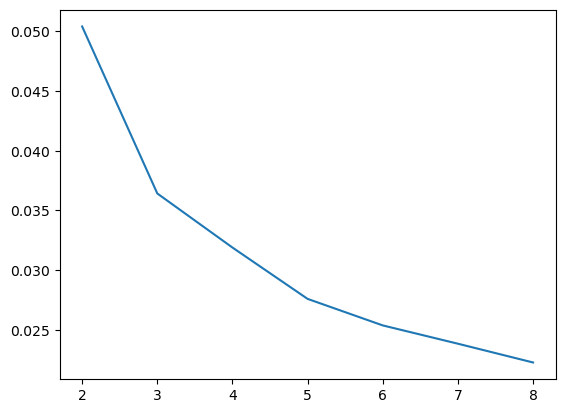

In [8]:
from scipy.cluster.vq import kmeans, vq

distortion = np.empty(7)
num_clusters = [i for i in range(2,9)]

for i, number in enumerate(num_clusters):
    centroids, distortion[i] = kmeans(X, number)
    
# In this example, looks like either 3 or 5 is good
plt.plot(num_clusters, distortion)
plt.show()

In [24]:
# from sklearn.metrics import silhouette_samples, silhouette_score

# num_clusters = [i for i in range(2,9)]

# # Calculate the silhouette score for each number in num_clusters
# for i, n in enumerate(num_clusters):
#     # Same as the other kmeans, instantiate the kmeans model
#     clusterer = cluster.KMeans(n_clusters = n, random_state=10)
#     # Predict cluster labels
#     cluster_labels = clusterer.fit_predict(X)
    
#     # Calculate the sihouette score for each individual cluster label
#     # DON'T use silhouette samples, that finds the score for EACH sample.
#     ### Appears to be the silhouette score that is slowing everything down ###
#     ### DONT USE FOR LARGE DATASETS ###
#     silhouette_avg[i] = silhouette_score(X, cluster_labels)
#     print("For n_clusters =", n,
#           "The average silhouette_score is :", silhouette_avg[i])
# plt.plot(num_clusters, silhouette_avg)
# plt.xticks(num_clusters)
# plt.show()

In [ ]:
%matplotlib qt5
fig, ax = plt.subplots(1,2, figsize = (20,10))
i = ax[1].imshow(X_cluster, cmap="tab20")
ax[0].imshow(rio.plot.reshape_as_image(tcc_stretch[:, 1500:2000, 750:1250]))
ep.draw_legend(im_ax = i, titles = [f"Class {num}" for num in range(5)], cmap = "tab20")
plt.tight_layout()

In [9]:
### LAND USE DICTIONARY ###
landuse_map = {
    1: "water", 
    2: "urban",
    3: "rice paddy",
    4: "crop",
    5: "grass",
    6: "DBF", # deciduous broad-leaf forest
    7: "DNF", # deciduous needle-leaf forest
    8: "EBF", # evergreen broad-leaf forest
    9: "ENF", # evergreen needle-leaf forest
    10: "bare land",
    11: "bamboo",
    12: "solar panel"
}

In [25]:
# Because our landuse dataset is a much higher resolution than our multiband image, we're going to
# have to downsample it 

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 9918, 'height': 7884, 'count': 1, 'crs': CRS.from_epsg(3098), 'transform': Affine(8.505747126436782, 0.0, 547579.0,
       0.0, -8.504946727549468, 3667730.0), 'blockysize': 1, 'tiled': False, 'compress': 'deflate', 'interleave': 'band'}

In [10]:
from rasterio.enums import Resampling

# we need to resample the land_use geotiff because it has a 10m scale
with rio.open("nagasaki_land_use.tif") as dataset:

    # resample data to target shape
    data = dataset.read(
        out_shape=(
            dataset.count,
            nir.shape[0], # height and width of our cropped study area - this will force the 
            nir.shape[1]  # opened landuse dataset into this shape
        ),
        resampling=Resampling.nearest # nearest is good for land use
    )
    
    # scale image transform
    transform = dataset.transform * dataset.transform.scale(
        (dataset.width / data.shape[-1]),
        (dataset.height / data.shape[-2])
    )
    
    profile = dataset.profile
    profile.update(transform = transform, 
                   width = data.shape[-1], 
                   height = data.shape[-2])
    
dataset.close()

In [72]:
# Basic cleaning: combine DBF+DNF and EBF+ENF and rice paddy + crop

### LAND USE DICTIONARY ###
landuse_map_old = {
    1: "water", 
    2: "urban",
    3: "rice paddy",
    4: "crop",
    5: "grass",
    6: "DBF", # deciduous broad-leaf forest
    7: "DNF", # deciduous needle-leaf forest
    8: "EBF", # evergreen broad-leaf forest
    9: "ENF", # evergreen needle-leaf forest
    10: "bare land",
    11: "bamboo",
    12: "solar panel"
}

# Combine rice paddy with crops
data[data == 3] = 4

# Combine deciduous, evergreen, and bamboo into Forest
data[((data > 5) & (data < 10)) | (data == 11)] = 6

data[data == 12] = 2

# np.unique(data)

landuse_map = {
    1: "water", 
    2: "urban",
    4: "crop",
    5: "grass",
    6: "forest",
    10: "bare land"
}

In [38]:
import earthpy.plot as ep

# extent = data[0,1000:1250,1750:2000]
# extent = data[0,600:650,2100:2150]
extent = data[0,:,:]

fig, ax = plt.subplots()
# im_ax = ax.imshow(data[0,:,:], cmap = "tab20")
i = ax.imshow(extent, cmap = "tab20")
# fig.colorbar(i, ax = ax)
# show(data, cmap = "tab20", ax = ax)

ep.draw_legend(im_ax = i, titles = [landuse_map[key] for key in np.unique(extent)], cmap = "tab20")

In [ ]:
show(tcc_stretch[:, 1500:2000, 750:1250])

In [12]:
%matplotlib qt5
# JAXA Landuse
extent = data[0,1500:2000, 750:1250]

fig, ax = plt.subplots(1,3, figsize = (20,10))
kmeans = ax[2].imshow(X_cluster, cmap="tab20")
ax[0].imshow(rio.plot.reshape_as_image(tcc_stretch[:, 1500:2000, 750:1250]))
landuse = ax[1].imshow(extent, cmap = "tab20")
ep.draw_legend(im_ax = kmeans, titles = [f"Class {num}" for num in range(5)], cmap = "tab20")
ep.draw_legend(im_ax = landuse, titles = [landuse_map[key] for key in np.unique(extent)], cmap = "tab20")
plt.tight_layout()

In [8]:
testset = dataset.swapaxes(0,2).reshape(2235 * 2812, 7)

nagasaki_classified = k_means.predict(testset) # Use fit_predict to train on data

# NOTE the order of the reshape matters because we swapped axes
# We must reshape width,height, then transpose
nagasaki_reshaped = nagasaki_classified.reshape(2812,2235).T

In [20]:
from matplotlib.colors import ListedColormap
%matplotlib qt5

# WTF you can specify xkcd colors with prefix "xkcd:": https://xkcd.com/color/rgb/
cmap = ListedColormap(["blue", "green", "cyan", "xkcd:lime green", "grey"], name = "LULC")

fig, ax = plt.subplots(1,2,figsize = (20,10))
ax[0].imshow(rio.plot.reshape_as_image(tcc_stretch))
kmeans = ax[1].imshow(nagasaki_reshaped, cmap = cmap, interpolation='nearest')
ep.draw_legend(im_ax = kmeans, titles = [f"Class {num}" for num in range(5)], cmap = cmap)

# show(nagasaki_classified.reshape(2812,2235).T, cmap = "Dark2", ax = ax)

In [23]:
show(tcc_stretch)

<Axes: >

In [22]:
counterexample = k_means.fit_predict(testset)

counterexample = counterexample.reshape(2812,2235).T

C:\Users\tranq\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [24]:
# Training on the Full data resulted in bad results - the sediment in the ocean was classified as 
# a different class
cmap = ListedColormap(["cyan", "green", "blue", "grey", "xkcd:lime green"], name = "LULC")

fig, ax = plt.subplots(1,2,figsize = (20,10))
ax[0].imshow(rio.plot.reshape_as_image(tcc_stretch))
kmeans = ax[1].imshow(counterexample, cmap = cmap, interpolation='nearest')
ep.draw_legend(im_ax = kmeans, titles = [f"Class {num}" for num in range(5)], cmap = cmap)